In [226]:
import pyedflib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import math
from scipy.signal import butter, sosfilt, lfilter, sosfiltfilt
from scipy.fft import fft, fftfreq
import scipy

In [116]:
from load_data import Subject_Session_Data
# from preprocess import butter_bandpass_filter

In [224]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [lowcut, highcut], analog=False, fs=fs, btype='band', output='sos')
    filtered = sosfiltfilt(sos, data)
    return filtered

In [105]:
work_dir = os.path.dirname(os.path.dirname(os.getcwd()))
dataset_dir = os.path.join(work_dir, "enterface06_EMOBRAIN", "Data")
dataset_common_dir = os.path.join(dataset_dir, "Common")
dataset_EEG_dir = os.path.join(dataset_dir, "EEG")
dataset_fNIRS_dir = os.path.join(dataset_dir, "fNIRS")

print("working with dataset directory:", dataset_dir)

# Construct the search pattern
pattern = os.path.join(dataset_EEG_dir, "*.bdf")

# Find all files in the directory matching the pattern
bdf_files = glob.glob(pattern)

count = 1
data_list = []
for file in bdf_files:
        # Open the BDF file
        try:
                with pyedflib.EdfReader(file) as f:
                        # marks = []
                        print("reading file :", count)
                        participant_index = file.find("Part")
                        session_index = file.find("SES")
                        participant_number = int(file[participant_index+4])
                        # print("Participant number:", participant_number)
                        session_number = int(file[session_index+3])
                        # print("Session number:", session_number)
                        if participant_number == 2 and session_number == 1:
                                continue
                        fi = open(file+".mrk", "r")
                        fi.readline()
                        inferred_temp_marks = []
                        for line in fi:
                                temp_marks = line.split('\t')[1:]
                                temp_marks[-1] = temp_marks[-1][:-1]
                                if temp_marks[-1] == '"255"':
                                        if temp_marks[0] == temp_marks[1]:
                                                inferred_temp_marks.append(int(temp_marks[0]))
                                        else:
                                                print("Irregular:", temp_marks)

                        block_sample_ranges = []
                        for trigger in inferred_temp_marks:
                                if participant_number == 1 and session_number == 1:
                                        start_index = trigger + 768
                                        end_index = start_index + 3200
                                        block_sample_ranges.append((start_index,end_index))
                                else:
                                        start_index = trigger + 3072
                                        end_index = start_index + 12800
                                        block_sample_ranges.append((start_index,end_index))

                        data_list.append(Subject_Session_Data(f, count, participant_number, session_number, inferred_temp_marks, block_sample_ranges))
                        '''
                        # Get general information
                        print("reading file :", count)
                        print("File duration in seconds:", f.file_duration)
                        print("Number of signals:", f.signals_in_file)
                        signal_labels = f.getSignalLabels()
                        print("Signal labels:", signal_labels)

                        # Read data from each signal
                        for i in range(f.signals_in_file):
                                data = f.readSignal(i)
                                print(f"Data from signal {signal_labels[i]}:", data)
                        '''
        except (OSError):
                print("reading file :", count, "FAIL")
        count += 1

emotion_classes = os.path.join(dataset_common_dir, "IAPS_Classes_EEG_fNIRS.txt")
emotion_file = open(emotion_classes, "r")
session1 = []
session2 = []
session3 = []
for line in emotion_file:
        temp_emotions = line.split("\t")
        temp_emotions[-1] = temp_emotions[-1][:-1]
        session1.append(temp_emotions[0])
        session2.append(temp_emotions[1])
        session3.append(temp_emotions[2])

for subject_session in data_list:
        if subject_session.session_number == 1:
                subject_session.emotions = session1
        elif subject_session.session_number == 2:
                subject_session.emotions = session2
        elif subject_session.session_number == 3:
                subject_session.emotions = session3

working with dataset directory: /Users/magizhshankar/Documents/CS 545/Final Project/enterface06_EMOBRAIN/Data
reading file : 1
reading file : 2
reading file : 2
reading file : 3
reading file : 4
reading file : 5
reading file : 6
reading file : 7
reading file : 8
reading file : 9
reading file : 10
reading file : 11
reading file : 12
reading file : 13
reading file : 14


In [106]:
data_list[4].display_info()

file number: 5
File duration in seconds: 1338
Number of signals: 72
Number of samples: 1370112
Participant number: 4
Session number: 3
Emotions ['Pos', 'Neg', 'Calm', 'Pos', 'Pos', 'Neg', 'Calm', 'Neg', 'Calm', 'Calm', 'Neg', 'Neg', 'Calm', 'Pos', 'Pos', 'Calm', 'Neg', 'Pos', 'Neg', 'Calm', 'Pos', 'Calm', 'Calm', 'Neg', 'Pos', 'Calm', 'Pos', 'Pos', 'Neg', 'Neg']


In [107]:
test_signal = data_list[0]
fs = 1024

In [108]:
def plot_signal(data, title):
    t = np.arange(data.shape[0])
    plt.figure(figsize=(12,5))
    plt.plot(t,data)
    plt.xlim([t[0],t[-1]])
    plt.ylim([min(data), max(data)])
    plt.xlabel('time (sec)')
    plt.grid()
    plt.title(title)
    plt.show()

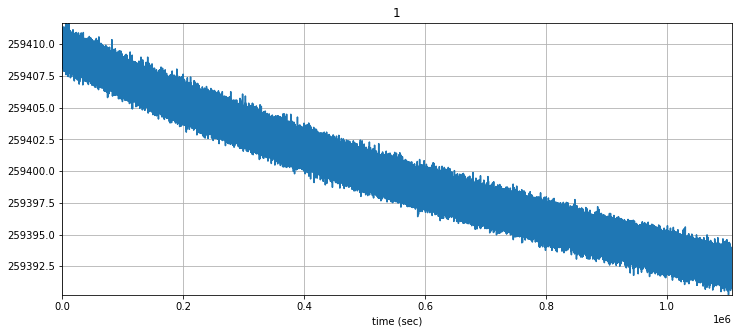

In [201]:
test_signal_labels = test_signal.signal_labels
test_data_dic = test_signal.data_dictionary
index = 5
test_data = test_data_dic[test_signal_labels[index]]
plot_signal(test_data, '1')

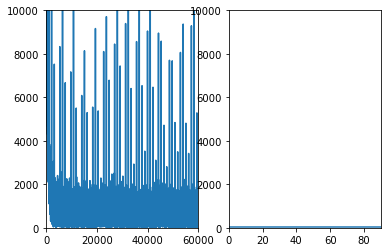

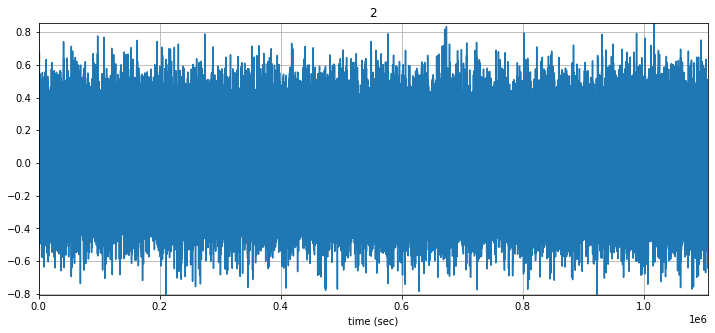

In [230]:
# bandpass in the 4-45 Hz range
lowcut = 4
highcut = 45
count_nan = 0
count_inf = 0
filtered = butter_bandpass_filter(test_data, lowcut, highcut, fs)
for i in range(len(filtered)):
    if math.isnan(filtered[i]):
        count_nan += 1
    elif math.isinf(filtered[i]):
        count_inf += 1

tt = fft(test_data)
plt.subplot(1,2,1)
plt.xlim(0, 60000)
plt.ylim(0, 10000)
plt.plot(np.abs(tt))

plt.subplot(1,2,2)
yf = fft(filtered)
# xf = fftfreq(len(filtered), 1 / fs)
plt.xlim(0,90)
plt.ylim(0, 10000)
plt.plot(np.abs(yf))
plt.show()

plot_signal(filtered[100:], '2')

In [99]:
signals_2d = [butter_bandpass_filter(test_data_dic[key], lowcut, highcut, fs) for key in test_data_dic]
signals_2d = np.array(signals_2d)

ica = FastICA(n_components=20)
ica_sources = ica.fit_transform(signals_2d)
reconstructed_signals = ica.inverse_transform(ica_sources)